<a href="http://www.stfc.ac.uk/"> <img src="../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# Overfitting

The aim of a machine learning project is to predict future values, by building a model that fits some known past ones. If the model underfits the features of training set, then it will not be optimal. But if it overfits chance aspects of the training set, then again it will fail to generalise to future data. This presentation explores these issues.

Let's begin by looking at a set of classifier functions. The X data will consist of several dimensions, with values ranging from -1 to +1. 


In [4]:
import random

def get_xs(n_samples, n_dimensions):
    #gather training data from a random uniform distribution
    training_set = [ [ random.uniform(-1.0,1.0) for d in range(0,n_dimensions) ]   for s in range(0, n_samples)]
    #gather test data from a random uniform distribution
    test_set = [ [ random.uniform(-1.0,1.0) for d in range(0,n_dimensions) ]   for s in range(0, n_samples)]
    return (training_set, test_set)


A machine learning method involves a set of possible model functions, one of which will be learnt; and also a way of selecting among these functions. Our method will consist of choosing the first k dimensions, and fitting a linear classifier. The larger k is, the larger the *capacity* of the method. This is its ability to fit data - including to overfit. 

In [5]:
from sklearn import linear_model

#save the model with the appropriate arguments
model = linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
     C=1000000000, # prevent regularisation 
     fit_intercept=False, 
     solver='liblinear', max_iter=100,  
     warm_start=False
) 

def get_fit(k, y_train, y_test):
    #select all data from 0 to kth dimension
    x_train = [ lst[0:k] for lst in training_set ]
    x_test = [ lst[0:k] for lst in test_set ]
    #fit the model and return the scores for the training and test sets
    model.fit( x_train, y_train)
    return ( model.score(x_train, y_train), model.score(x_test, y_test) )


Our problem is drawn from a space of problems in which y is the sign of a weighted sum of the values in the vector $x_s$. The weight of the first dimension is one, then the weights tail off exponentially. 

In [6]:
from  matplotlib import pyplot as plt

def get_y(x, 
          a # parameter controlling the contribution of higher dimensions
         ): 
    return [
        0 < sum([ a**d * x[s][d] for d in range(0,len(x[0]))  ])   
        for s in range(0, len(x))
    ]
assert [True, False] == get_y([ [1, -9], [-1, 9] ], 0.1)


Let's see how the quality of the fit varies with the capacity of the model. We average over several repetitions for different values of x. 

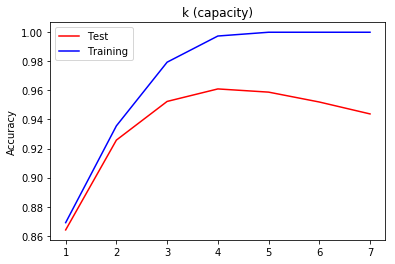

In [7]:
n_samples = 50
n_dimensions = 8
n_repetitions = 100

training_scores = []
test_scores = []
for k in range(1, n_dimensions):
    training_score = 0
    test_score = 0
    for i in range(0, n_repetitions):
        training_set, test_set = get_xs(n_samples, n_dimensions)
        y_train = get_y(training_set, 0.5)
        y_test = get_y(test_set, 0.5)
        tr, te = get_fit(k, y_train, y_test)
        training_score = training_score + tr
        test_score = test_score + te
    training_scores.append(training_score/n_repetitions)
    test_scores.append(test_score/n_repetitions)
    
plt.figure()

p1 = plt.plot(range(1, n_dimensions), test_scores, color='red' )  
p2 = plt.plot(range(1, n_dimensions), training_scores, color='blue' )

plt.ylabel('Accuracy')
plt.title('k (capacity)')
#plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Test', 'Training'))

plt.show()

The fit to the test set improves steadily with higher capacity. This not surprising: extra information can't make the found fit worse. This is also true in regression problems: in OLS regression adding another descriptor can never reduce the $R^2$ value for the test set, only increase it. 

The Empirical Risk Minimisation principle says to choose the model that has the best fit to the training set. In this case, it will lead us astray. The best fit to the test set is found with intermediate capacity. This is despite the fact that with our set of problems, all dimensions contribute to the y values. 

The error of our learning method on the test set consists of three parts:
- Bias: the difference between the actual function and the best fit to the test set in our space of models 
- Learning error: the difference between the best fit to the test set in our space of models and the fit our learning method actually found
- Overfit: the difference between the fit actually found to the test set, and the fit to the training set

To reduce bias, we must use prior knowledge to choose a suitable set of models. To reduce the learning error, we must choose a suitable training method. However, both choices are constrained by our lack of knowledge of the true function, and the compute resources available to us. We often have to settle for an imperfect method. It is still possible to deliver useful results.

Let's investigate the distribution of the overfit. This time, we will vary the parameter a of the true model.

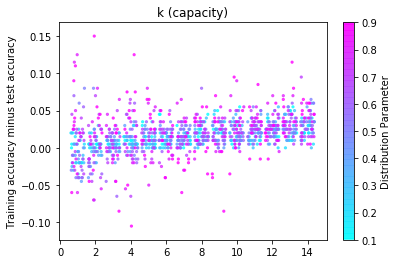

In [8]:
n_samples = 200
n_dimensions = 15
n_repetitions = 10

overfit = []
ks = []
a_s=[]
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for k in range(1, n_dimensions):
        #training_score = 0
        #test_score = 0
        for i in range(0, n_repetitions):
            training_set, test_set = get_xs(n_samples, n_dimensions)
            y_train = get_y(training_set, a)
            y_test = get_y(test_set, a)
            tr, te = get_fit(k, y_train, y_test)
            overfit.append(tr-te)
            ks.append(
                k+random.uniform(-0.4, 0.4) # jitter so we can see all the dots
            )
            a_s.append(a)
    
plt.figure()

p1 = plt.scatter(ks, overfit, alpha=0.7, s=5, c=a_s, cmap='cool' )  

plt.ylabel('Training accuracy minus test accuracy')
plt.title('k (capacity)')
plt.colorbar().set_label('Distribution Parameter')
plt.show()


For this set of problems, and this method, the least overfit seems to be for k=8. 

Sometimes we get lucky and the accuracy on the test set is actually better than on the training set. With real problems, this can also be a sign that your training set contains some odd molecules that are unrepresentative of the test data. 

The Structural Risk Minimisation Principle says that when selecting a model we should minimise not just the training error, but the training error plus a term representing the complexity of the model. This is called the "regularizer". In some of the methods used in this course there is a metaparameter that sets the weight of the regularization term. We can choose the regularization parameter by cross-validation.

The formal definition of capacity is *Vapnik-Chernovenkis Dimension*. It is defined as follows. Given a set of $n$ molecules to be classified, there are $2^n$ possible assignments of y values. If the modelling method to be used can train a perfect classifier for each of these, then it is said to *shatter* the set. The VC dimension of a method is the size of the largest set it can shatter. 

In the case of the modelling method used here, this is equal to k. We defined k as the number of dimensions to use in the logistic regression. This is also the number of learnt parameters, since we set fitIntercept=False. For different modelling methods, VC dimension can be either greater or less than the number of learnt parameters.


## Choosing descriptors
Note that our method allows choice of the number of dimensions, but not of which dimensions to use. If chemical descriptors are prioritised on physical grounds before examining the training set, then this is equivalent to our method.

Suppose that our classifier uses a single fixed descriptor, and a single cutoff value. Then it can shatter two molecules, but not three: it two have the same value it cannot distinguish them, and if they all have different values it cannot classify the set consisting only of the molecule with medial value.

If descriptors are chosen using the training set, then the situation is different. The opportunity to choose one descriptor from a set of $2^c$ independent descriptors has the same capacity as the use of $c$ prescribed descriptors.Choosing one of eight fragment descriptors could have the same potential to fit, and overfit, as the use of three prescribed descriptors. In practice, with the RDKit descriptors, and [an experiment](Shattering.ipynb) shows that it is easy find sets of four molecules that can be shattered by a free choice of descriptor. 

Here is a set of six drugs which can be shattered by choosing suitable RDKit descriptors:
- C1=CC(=CC=C1C=NNC2=CC=C(C=C2)Cl)\[N+\](=O)\[O-\]
- CC1=CC(=C2C(=C1)C3(C=C(C4(C(C3O2)(C5=CC(=CC(=C5O4)C)C)SC6=CC=CC=C6)O)C)C)C
- CC1=CC=C(C=C1)S(=O)C2C(N(OC2(CF)OC)C3=CC=CC=C3)C4=CC=CC=C4
- CC1=C(SC(=NC(=O)NCC2=CC=CC=C2)O1)C(=O)C
- CC1=C2CCCCC2=NN1C(=O)CCN3C4=CC=CC=C4SC5=CC=CC=C53
- CC(=O)OC1C2=CC=CC=C2C=NC1(C(=O)OC)C(=O)OC

Therefore the VC dimension of an RDKit descriptor chosen in the light of the training set is at least 6.

There are more than a thousand published molecule descriptors, and training sets are limited by the cost of experiment. So there is a risk of overfitting in cheminformatics.



## Further reading

For more information on the topics covered here:

- [Catherine Matacic, *Are algorithms good judges?*](http://science.sciencemag.org/content/359/6373/263.full)
- [The difference between ML and classical statistics](Optional/ClassicalStatistics.ipynb)
- [VC Dimension](https://en.wikipedia.org/wiki/VC_dimension)


[Up](../Welcome.ipynb) [Next](NearestNeighbour.ipynb) 

Copyright STFC 2018